# Collaborative filtering KNN based recommendation systems examples

## Imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('./src')

from scipy.spatial.distance import correlation, cosine

from ratings_matrix import RatingsMatrix
from dataset import MovielensDataset

from similarity import cosine_sim, \
                       pearson_sim, \
                       spearman_sim, \
                       adjusted_cosine_sim, \
                       spearman

from predictor import PredictorFactory, \
                      predict

from evaluator import Evaluator

from metric import RootMeanSquaredErrorMetric, \
                   MeanSquaredErrorMetric, \
                   PrecisionMetric, \
                   RecallMetric, \
                   FBetaMetric, \
                   MeanUserPrecisionKMetric, \
                   MeanUserFBetaKMetric, \
                   MeanAVGPrecisionKMetric, gte, between

from similarity import CommonSimilarityService, \
                       AdjustedCosineSimilarityService

from show import show_similar_items, \
                 show_similar_users, \
                 show_prediction

from util import group_by, \
                 most_common

import random
import numpy as np
import logging

In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(seed=SEED)

In [4]:
logging.basicConfig(
    format='%(asctime)s | %(levelname)s : %(message)s',
    level=logging.INFO,
    stream=sys.stdout
)

## User-Item Ratings Matrix

* [Ratings matrix](https://github.com/adrianmarino/cf-rec-sys-examples/blob/master/src/ratings_matrix.py) is a user-item ratings matrix where ratings are integers between 1 and 10.
* 6 users (rows) have rated 6 items (columns).

In [5]:
rm = RatingsMatrix([
    [3, 7, 4, 9,  9, 7], 
    [7, 0, 5, 3,  8, 8],
    [7, 5, 5, 0,  8, 4],
    [5, 6, 8, 5,  9, 8],
    [5, 8, 8, 8, 10, 9],
    [7, 7, 0, 4,  7, 8]
])
rm.shape

(6, 6)

User ratings / row values:

In [6]:
rm.row(1)

array([[3, 7, 4, 9, 9, 7]])

Mean user rating / row mean:

$\overline{Row}_i = \frac{1}{C}  \sum_{j=0}^{C-1} Value_{i, j}$

* $i$ is a row.
* $j$ is a column.
* $C$ is columns size.

In [7]:
rm.mean_row(1)

6.5

User rating deviance:

$Deviance_{i, j} = Value_{i, j} - \overline{Row}_i$

* $i$ is a row.
* $j$ is a column.

In [8]:
rm.row_deviation(1, 1)

-3.5

User(Row)-item(Column) rating:

In [9]:
rm.cell(3, 4)

0

Iterate each rating:

In [10]:
[f'rating: {r}, user_id: {u_id}, item_id: {i_id}' for r, u_id, i_id in rm.cells][:5]

['rating: 3, user_id: 1, item_id: 1',
 'rating: 7, user_id: 1, item_id: 2',
 'rating: 4, user_id: 1, item_id: 3',
 'rating: 9, user_id: 1, item_id: 4',
 'rating: 9, user_id: 1, item_id: 5']

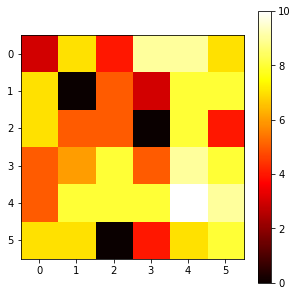

In [11]:
rm.plot()

## Users similarity

In [12]:
cosine_sim(rm)

,0,1,2,3,4,5
0,1.000000,0.799268,0.779227,0.934622,0.973890,0.884600
1,0.799268,1.000000,0.874744,0.905850,0.866146,0.827036
2,0.779227,0.874744,1.000000,0.909513,0.865454,0.853275
3,0.934622,0.905850,0.909513,1.000000,0.989344,0.865614
4,0.973890,0.866146,0.865454,0.989344,1.000000,0.881640
5,0.884600,0.827036,0.853275,0.865614,0.881640,1.000000


In [13]:
adjusted_cosine_sim(rm)

,0,1,2,3,4,5
0,1.000000,0.236908,0.421263,-0.519085,-0.125892,0.010090
1,0.236908,1.000000,-0.805243,0.085741,0.237273,0.520625
2,0.421263,-0.805243,1.000000,-0.767941,-0.230521,-0.053640
3,-0.519085,0.085741,-0.767941,1.000000,-0.299059,-0.644550
4,-0.125892,0.237273,-0.230521,-0.299059,1.000000,0.599158
5,0.010090,0.520625,-0.053640,-0.644550,0.599158,1.000000


## User based recomendation system using cosine similarity

### Similar users

[CommonSimilarityService](https://github.com/adrianmarino/cf-rec-sys-examples/blob/master/src/similarity/service/impl/common_similarity_service.py) class finds k similar users give a _user id_. in this case we use cosine similarity:


<center>$\Large cosine \mspace{3mu} distance_{a, b} = \frac{ \sum_{j \in C} r_{a, j}.r_{b, j}}{\sqrt{\sum_{j \in C} r_{a, j}^2}.\sqrt{\sum_{j \in C} r_{b, j}^2}  }$</center>



<center>$\Large cosine \mspace{3mu} similarity_{a, b} = 1 - cosine \mspace{3mu} distance_{a, b}$</center>



#### Observations

* $C$ is columns count in [Ratings matrix](https://github.com/adrianmarino/cf-rec-sys-examples/blob/master/src/ratings_matrix.py).
* $j$ is a column number.
* $a$ and $b$ are two rows in [Ratings matrix](https://github.com/adrianmarino/cf-rec-sys-examples/blob/master/src/ratings_matrix.py) 
of which we want to know how similar they are.
* $a$ and $b$ represent ratings of both users for all items (one for column).
* $ 0 <= cosine \mspace{3mu} similarity_{a, b} <= 1$. The higher the value the more similar.

In [14]:
n_neighbors = 4
user_id     = 1

predictor_factory = PredictorFactory()

sim_service = CommonSimilarityService(rm, cosine, n_neighbors)

similarities, indices = sim_service.similars(user_id)

show_similar_users(indices, similarities, user_id)

4 most similar users to user 1:

- User ID 5, with similarity of 0.9738899354018394.
- User ID 4, with similarity of 0.9346216841783769.
- User ID 6, with similarity of 0.8846004572297814.
- User ID 2, with similarity of 0.7992679780524188.


### User based predictor

[UserBasedPredictor](https://github.com/adrianmarino/cf-rec-sys-examples/blob/master/src/predictor/impl/user_based_predictor.py) class predicts ratings for specified user-item combinations based on user-based approach. Predictions are computed as weighted average of deviations from neighbor’s mean and adding it to active user’s mean rating.

<center>$\Large prediction_{u, i} = \overline{r}_u + \frac{\sum_{o \in K} (r_{o, i} - \overline{r}_o) . w_{u, o} }{ \sum_{o \in K} w_{u, o}}, u \neq o $</center>

#### Observations

* We seek to predict the rating than user $u$ gave to item $i$ calculating $prediction_{u, i}$.
* $o$ (other) user belongs to $K$, the set of all users similar to $u$ user.
* $w_{u,o}$ is the similarity between users $u$ and $o$ ($w_{u,o} = similarity_{u,o} = 1 - distance_{u,o}$).
* $K$ could be calculated using any subclass of [SimilarityService](https://github.com/adrianmarino/cf-rec-sys-examples/blob/master/src/similarity/service/similarity_service.py) ([CommonSimilarityService](https://github.com/adrianmarino/cf-rec-sys-examples/blob/master/src/similarity/service/impl/common_similarity_service.py) or [AdjustedCosineSimilarityService](https://github.com/adrianmarino/cf-rec-sys-examples/blob/master/src/similarity/service/impl/adjusted_cosine_similarity_service.py)).
* $\overline{r}_{u}$ is the mean of all ratings made by $u$ user.
* $r_{o,i} - \overline{r}_{o}$ is the diference between the $o$ user rating to $i$ item and $\overline{r}_{o}$ mean. Is used to adjust the user associated biases. User biases occur as certain users may tend to always give high or low ratings to all items.

In [15]:
evaluator = Evaluator(
    metrics=[
        MeanSquaredErrorMetric(),
        RootMeanSquaredErrorMetric(),
        PrecisionMetric(),
        RecallMetric(),
        FBetaMetric(),
        FBetaMetric(beta=0.5),
        FBetaMetric(beta=1.5),
        MeanAVGPrecisionKMetric(k=3, binarizer=between(10, 10)),
        MeanAVGPrecisionKMetric(k=3, binarizer=between(8,10)),
        MeanAVGPrecisionKMetric(k=3, binarizer=between(6,8))
    ]
)

In [16]:
predictor = predictor_factory.create('knn_cosine_user_based', rm, n_neighbors)

evaluator.evaluate(predictors=[predictor], rm=rm, transpose=True)

2022-03-15 13:53:14,580 | INFO : Performing knn_cosine_user_based MSE...
2022-03-15 13:53:14,581 | INFO : Performing knn_cosine_user_based RMSE...
2022-03-15 13:53:14,581 | INFO : Performing knn_cosine_user_based Precision...
2022-03-15 13:53:14,582 | INFO : Performing knn_cosine_user_based Recall...
2022-03-15 13:53:14,583 | INFO : Performing knn_cosine_user_based F1Score...
2022-03-15 13:53:14,584 | INFO : Performing knn_cosine_user_based F0.5Score...
2022-03-15 13:53:14,585 | INFO : Performing knn_cosine_user_based F1.5Score...
2022-03-15 13:53:14,586 | INFO : Performing knn_cosine_user_based MeanAVGPrecision@3(10,10)...
2022-03-15 13:53:14,587 | INFO : Performing knn_cosine_user_based MeanAVGPrecision@3(8,10)...
2022-03-15 13:53:14,589 | INFO : Performing knn_cosine_user_based MeanAVGPrecision@3(6,8)...


Predictor,knn_cosine_user_based
MSE,4.5285
RMSE,2.1280
Precision,0.2774
Recall,0.2566
F1Score,0.2438
F0.5Score,0.2574
F1.5Score,0.2433
"MeanAVGPrecision@3(10,10)",0.1042
"MeanAVGPrecision@3(8,10)",0.4306
"MeanAVGPrecision@3(6,8)",0.5332


In [17]:
user_id = 3
item_id = 4

show_prediction(rm, user_id, item_id, predictor.predict(user_id, item_id))

Item base rating prediction:
- User ID: 3.
- Item ID: 4.
- Predicted rating: 3.450903595941009.
- Real rating: 0 (0 == unrated item).


In [18]:
user_id = 1
item_id = 5

show_prediction(rm, user_id, item_id, predictor.predict(user_id, item_id))

Item base rating prediction:
- User ID: 1.
- Item ID: 5.
- Predicted rating: 8.60564770282165.
- Real rating: 9 (0 == unrated item).


## Item based recommedation system using cosine similarity

### Similar items

[CommonSimilarityService](https://github.com/adrianmarino/cf-rec-sys-examples/blob/master/src/similarity/service/impl/common_similarity_service.py) class finds k similar items given the _item_id_ and a transposed version of ratings matrix.

In [19]:
item_id = 3

sim_service = CommonSimilarityService(rm.T(), cosine, n_neighbors)

similarities, indices = sim_service.similars(item_id)

show_similar_items(indices, similarities, item_id)

4 most similar items to item 3:

- Item ID 5, with similarity of 0.9183361255345218.
- Item ID 6, with similarity of 0.874759773038195.
- Item ID 1, with similarity of 0.8103647462221735.
- Item ID 4, with similarity of 0.7969178003023931.


### Item based predict

In this approach, similarities between pair of items are computed using $cosine \mspace{3mu} similarity \mspace{3mu}$ ($1 - cosine \mspace{3mu} distance$). The rating for target item $i$ for active user $a$ can be predicted by using a simple weighted average as:

<center>$\Large prediction_{u, i} = \frac{\sum_{j \in K} r_{u, j}. w_{i, j} }{\sum_{j \in K} w_{i, j} }, i \neq j $</center>

#### Observations

* We seek to predict the rating than user $u$  gave to item $i$ calculating $prediction_{u,i}$.
* $K$ is the neighborhood of $j$ items most similar to $i$ item. $j$ belongs to $K$ and $i \neq j$. 
* $w_{i,j}$ is the similarity between items $i$ and $j$ ($w_{i,j}$ = $similarity_{i,j} = 1 - distance_{i,j}$).

In [20]:
predictor = predictor_factory.create('knn_cosine_item_based', rm, n_neighbors)

In [21]:
evaluator.evaluate(predictors=[predictor], rm=rm, transpose=True)

2022-03-15 13:53:14,715 | INFO : Performing knn_cosine_item_based MSE...
2022-03-15 13:53:14,716 | INFO : Performing knn_cosine_item_based RMSE...
2022-03-15 13:53:14,716 | INFO : Performing knn_cosine_item_based Precision...
2022-03-15 13:53:14,717 | INFO : Performing knn_cosine_item_based Recall...
2022-03-15 13:53:14,718 | INFO : Performing knn_cosine_item_based F1Score...
2022-03-15 13:53:14,719 | INFO : Performing knn_cosine_item_based F0.5Score...
2022-03-15 13:53:14,719 | INFO : Performing knn_cosine_item_based F1.5Score...
2022-03-15 13:53:14,720 | INFO : Performing knn_cosine_item_based MeanAVGPrecision@3(10,10)...
2022-03-15 13:53:14,721 | INFO : Performing knn_cosine_item_based MeanAVGPrecision@3(8,10)...
2022-03-15 13:53:14,723 | INFO : Performing knn_cosine_item_based MeanAVGPrecision@3(6,8)...


Predictor,knn_cosine_item_based
MSE,6.4003
RMSE,2.5299
Precision,0.0833
Recall,0.0935
F1Score,0.0871
F0.5Score,0.0846
F1.5Score,0.0892
"MeanAVGPrecision@3(10,10)",0.0000
"MeanAVGPrecision@3(8,10)",0.2037
"MeanAVGPrecision@3(6,8)",0.6111


In [22]:
user_id = 4
item_id = 3

show_prediction(rm, user_id, item_id, predictor.predict(user_id, item_id))

Item base rating prediction:
- User ID: 4.
- Item ID: 3.
- Predicted rating: 7.742467352632247.
- Real rating: 8 (0 == unrated item).


## Item based recommedation system using adjusted cosine similarity

### Similar items

Using cosine similarity metric for item-based CF approach **does not consider difference in ratings of users**. Adjusted cosine similarity offsets this drawback by subtracting respective user’s average rating ($\overline{r}_u$) from each co-rated pair, and is defined as below:

<center>$\Large adj. \mspace{3mu} cosine \mspace{3mu} distance_{i, j} = \frac{ \sum_{u \in U} (r_{u, i} - \overline{r}_{u}).(r_{u, j} - \overline{r}_{u})}{\sqrt{ \sum_{u \in U} (r_{u, i} - \overline{r}_{u})^2}.\sqrt{ \sum_{u \in U} (r_{u, j} - \overline{r}_{u})^2}}$</center>



<center>$\Large adj. \mspace{3mu} cosine \mspace{3mu} similarity_{i, j} = 1 - adj. \mspace{3mu} cosine \mspace{3mu} distance_{i, i}$</center>

#### Observations

* $U$ all users in [Ratings matrix](https://github.com/adrianmarino/cf-rec-sys-examples/blob/master/src/ratings_matrix.py).
* $u$ a given user.
* $\overline{r}_{u}$ mean rating of $u$ user.
* $i$ and $j$ represent two items.

[AdjustedCosineSimilarityService](https://github.com/adrianmarino/cf-rec-sys-examples/blob/master/src/similarity/service/impl/adjusted_cosine_similarity_service.py) class finds k similar items given the _item_id_ and ratings matrix.

In [23]:
user_id = 3 

sim_service = AdjustedCosineSimilarityService(rm, n_neighbors)

similarities, indices = sim_service.similars(item_id)

show_similar_items(indices, similarities, item_id)

4 most similar items to item 3:

- Item ID 1, with similarity of 0.42126273187113467.
- Item ID 6, with similarity of -0.05363989048891138.
- Item ID 5, with similarity of -0.2305213582693748.
- Item ID 4, with similarity of -0.7679410465751941.


### Item based predictor

In [24]:
predictor = predictor_factory.create('knn_adj_cosine_item_based', rm, n_neighbors)
evaluator.evaluate(predictors=[predictor], rm=rm, transpose=True)

2022-03-15 13:53:14,847 | INFO : Performing knn_adj_cosine_item_based MSE...
2022-03-15 13:53:14,848 | INFO : Performing knn_adj_cosine_item_based RMSE...
2022-03-15 13:53:14,848 | INFO : Performing knn_adj_cosine_item_based Precision...
2022-03-15 13:53:14,849 | INFO : Performing knn_adj_cosine_item_based Recall...
2022-03-15 13:53:14,850 | INFO : Performing knn_adj_cosine_item_based F1Score...
2022-03-15 13:53:14,851 | INFO : Performing knn_adj_cosine_item_based F0.5Score...
2022-03-15 13:53:14,852 | INFO : Performing knn_adj_cosine_item_based F1.5Score...
2022-03-15 13:53:14,853 | INFO : Performing knn_adj_cosine_item_based MeanAVGPrecision@3(10,10)...
2022-03-15 13:53:14,854 | INFO : Performing knn_adj_cosine_item_based MeanAVGPrecision@3(8,10)...
2022-03-15 13:53:14,856 | INFO : Performing knn_adj_cosine_item_based MeanAVGPrecision@3(6,8)...


Predictor,knn_adj_cosine_item_based
MSE,13.6386
RMSE,3.6931
Precision,0.2762
Recall,0.3254
F1Score,0.2660
F0.5Score,0.2657
F1.5Score,0.2767
"MeanAVGPrecision@3(10,10)",0.2500
"MeanAVGPrecision@3(8,10)",0.5154
"MeanAVGPrecision@3(6,8)",0.5694


In [25]:
user_id = 1
item_id = 1

show_prediction(rm, user_id, item_id, predictor.predict(user_id, item_id))

Item base rating prediction:
- User ID: 1.
- Item ID: 1.
- Predicted rating: 4.205640412693527.
- Real rating: 3 (0 == unrated item).


## Predict and evaluate

Evaluate all recomendation systems with distinct dsitance measures under example rating matrix.

In [26]:
%%time
predictors = predictor_factory.create_all(rm, n_neighbors)

CPU times: user 17.5 ms, sys: 41.3 ms, total: 58.8 ms
Wall time: 84.1 ms


In [27]:
user_id=1
item_id=5

print('True rating:', rm.cell(user_id, item_id))
predict(predictors, user_id, item_id)

True rating: 9


,Prediction
Predictor,
knn_cosine_user_based,8.61
knn_cosine_item_based,6.84
knn_pearson_user_based,8.30
knn_pearson_item_based,0.00
knn_adj_cosine_item_based,9.49
knn_euclidean_user_based,0.00
knn_euclidean_item_based,0.00
knn_minkowski_user_based,0.00
knn_minkowski_item_based,0.00


if the item is already rated, it is not recommended:

In [28]:
user_id=2
item_id=1

print('True rating:', rm.cell(user_id, item_id))
predict(predictors, user_id, item_id)

True rating: 7


,Prediction
Predictor,
knn_cosine_user_based,4.84
knn_cosine_item_based,6.50
knn_pearson_user_based,5.19
knn_pearson_item_based,5.37
knn_adj_cosine_item_based,3.86
knn_euclidean_user_based,0.00
knn_euclidean_item_based,0.00
knn_minkowski_user_based,0.00
knn_minkowski_item_based,0.00


Evaluate predictions using _RMSE_ and _MAE_ error metrics:

In [29]:
evaluator.evaluate(predictors, rm) \
    .sort_values(by='MeanAVGPrecision@3(10,10)', ascending=False) \
    .style.hide(axis='index')

2022-03-15 13:53:15,248 | INFO : Performing knn_cosine_user_based MSE...
2022-03-15 13:53:15,249 | INFO : Performing knn_cosine_item_based MSE...
2022-03-15 13:53:15,250 | INFO : Performing knn_pearson_user_based MSE...
2022-03-15 13:53:15,250 | INFO : Performing knn_pearson_item_based MSE...
2022-03-15 13:53:15,250 | INFO : Performing knn_adj_cosine_item_based MSE...
2022-03-15 13:53:15,251 | INFO : Performing knn_euclidean_user_based MSE...
2022-03-15 13:53:15,251 | INFO : Performing knn_euclidean_item_based MSE...
2022-03-15 13:53:15,251 | INFO : Performing knn_minkowski_user_based MSE...
2022-03-15 13:53:15,252 | INFO : Performing knn_minkowski_item_based MSE...
2022-03-15 13:53:15,252 | INFO : Performing knn_mahalanobis_user_based MSE...
2022-03-15 13:53:15,252 | INFO : Performing knn_mahalanobis_item_based MSE...
2022-03-15 13:53:15,253 | INFO : Performing knn_chebyshev_user_based MSE...
2022-03-15 13:53:15,253 | INFO : Performing knn_chebyshev_item_based MSE...
2022-03-15 13:53:

Predictor,MSE,RMSE,Precision,Recall,F1Score,F0.5Score,F1.5Score,"MeanAVGPrecision@3(10,10)","MeanAVGPrecision@3(8,10)","MeanAVGPrecision@3(6,8)"
knn_cosine_user_based,4.528500,2.128000,0.277400,0.256600,0.243800,0.257400,0.243300,0.159700,0.408200,0.550200
knn_adj_cosine_item_based,13.638600,3.693100,0.276200,0.325400,0.266000,0.265700,0.276700,0.125000,0.539400,0.508500
knn_pearson_user_based,3.288800,1.813500,0.333300,0.269000,0.290800,0.312300,0.280900,0.083300,0.368800,0.598800
knn_cosine_item_based,6.400300,2.529900,0.083300,0.093500,0.087100,0.084600,0.089200,0.000000,0.203700,0.611100
knn_pearson_item_based,13.730800,3.705500,0.074100,0.096100,0.082300,0.076900,0.086800,0.000000,0.203700,0.305600
knn_euclidean_user_based,44.305600,6.656200,0.009300,0.111100,0.017100,0.011300,0.025300,0.000000,0.000000,0.000000
knn_euclidean_item_based,44.305600,6.656200,0.009300,0.111100,0.017100,0.011300,0.025300,0.000000,0.000000,0.000000
knn_minkowski_user_based,44.305600,6.656200,0.009300,0.111100,0.017100,0.011300,0.025300,0.000000,0.000000,0.000000
knn_minkowski_item_based,44.305600,6.656200,0.009300,0.111100,0.017100,0.011300,0.025300,0.000000,0.000000,0.000000
knn_mahalanobis_user_based,44.305600,6.656200,0.009300,0.111100,0.017100,0.011300,0.025300,0.000000,0.000000,0.000000


## Using Movie Lens dataset

### User-Item Ratings Matrix

In [30]:
%%time
dataset = MovielensDataset(n_users=200, n_movies=200)
rating_table = dataset.ratings()

group_by(rating_table, 'rating').T

CPU times: user 24.5 ms, sys: 7.08 ms, total: 31.6 ms
Wall time: 31.1 ms


,0,1,2,3,4,5,6,7,8,9
rating,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
count,103.0,233.0,131.0,759.0,610.0,2565.0,2196.0,4955.0,1895.0,3061.0


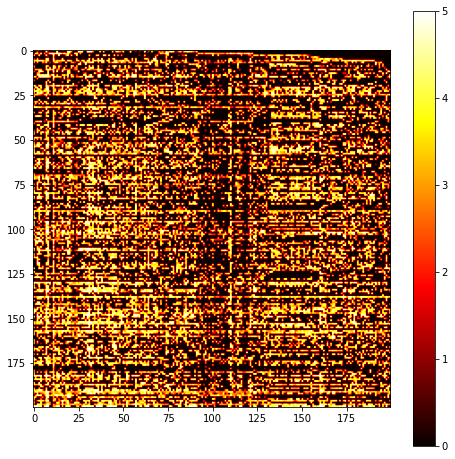

Size: (200, 200)
CPU times: user 435 ms, sys: 12.6 ms, total: 448 ms
Wall time: 451 ms


In [31]:
%%time
rm = RatingsMatrix.from_df(rating_table, rows='user_seq', columns='movie_seq', value='rating')

rm.plot((8, 8))
print(f'Size: {rm.shape}')

## Evaluate all recomendations system combinations

In [32]:
user_id = most_common(rating_table, 'user_seq',  limit=20)[-1]
item_id = most_common(rating_table, 'movie_seq', limit=20)[-1]

In [33]:
%%time
predictors = predictor_factory.create_all(rm, n_neighbors=20)

CPU times: user 52.5 ms, sys: 75.4 ms, total: 128 ms
Wall time: 1min 58s


In [34]:
%%time
print('True rating:', rm.cell(user_id, item_id))
predict(predictors, user_id, item_id)

True rating: 3.5
CPU times: user 17.3 ms, sys: 48.9 ms, total: 66.2 ms
Wall time: 86.5 ms


,Prediction
Predictor,
knn_cosine_user_based,3.30
knn_cosine_item_based,4.17
knn_pearson_user_based,4.28
knn_pearson_item_based,3.87
knn_adj_cosine_item_based,4.14
knn_euclidean_user_based,0.00
knn_euclidean_item_based,0.00
knn_minkowski_user_based,0.00
knn_minkowski_item_based,0.00


In [35]:
evaluator = Evaluator(
    metrics=[
        MeanSquaredErrorMetric(),
        RootMeanSquaredErrorMetric(),
        
        MeanAVGPrecisionKMetric(k=5, binarizer=between(5, 5)),
        MeanAVGPrecisionKMetric(k=5, binarizer=between(4,5)),

        MeanAVGPrecisionKMetric(k=10, binarizer=between(5, 5)),
        MeanAVGPrecisionKMetric(k=10, binarizer=between(4,5)),
        
        MeanAVGPrecisionKMetric(k=30, binarizer=between(5, 5)),
        MeanAVGPrecisionKMetric(k=30, binarizer=between(4,5)),

        MeanUserPrecisionKMetric(k=5),
        MeanUserPrecisionKMetric(k=10),
        MeanUserPrecisionKMetric(k=30),

        MeanUserFBetaKMetric(k=5,  beta=.5),
        MeanUserFBetaKMetric(k=10, beta=.5),
        MeanUserFBetaKMetric(k=30, beta=.5),

        MeanUserFBetaKMetric(k=5,  beta=1),
        MeanUserFBetaKMetric(k=10, beta=1),
        MeanUserFBetaKMetric(k=30, beta=1),

        MeanUserFBetaKMetric(k=5,  beta=1.5),
        MeanUserFBetaKMetric(k=10, beta=1.5),
        MeanUserFBetaKMetric(k=30, beta=1.5)
    ]
)

In [36]:
%%time
metrics = evaluator.evaluate(predictors, rm)

2022-03-15 13:59:26,730 | INFO : Performing knn_cosine_user_based MSE...
2022-03-15 13:59:26,731 | INFO : Performing knn_cosine_item_based MSE...
2022-03-15 13:59:26,732 | INFO : Performing knn_pearson_user_based MSE...
2022-03-15 13:59:26,732 | INFO : Performing knn_pearson_item_based MSE...
2022-03-15 13:59:26,733 | INFO : Performing knn_adj_cosine_item_based MSE...
2022-03-15 13:59:26,733 | INFO : Performing knn_euclidean_user_based MSE...
2022-03-15 13:59:26,734 | INFO : Performing knn_euclidean_item_based MSE...
2022-03-15 13:59:26,734 | INFO : Performing knn_minkowski_user_based MSE...
2022-03-15 13:59:26,735 | INFO : Performing knn_minkowski_item_based MSE...
2022-03-15 13:59:26,736 | INFO : Performing knn_mahalanobis_user_based MSE...
2022-03-15 13:59:26,736 | INFO : Performing knn_mahalanobis_item_based MSE...
2022-03-15 13:59:26,736 | INFO : Performing knn_chebyshev_user_based MSE...
2022-03-15 13:59:26,737 | INFO : Performing knn_chebyshev_item_based MSE...
2022-03-15 13:59:

In [38]:
metrics \
    .sort_values(by='MeanAVGPrecision@5(4,5)', ascending=False) \
    .style.hide(axis='index')

Predictor,MSE,RMSE,"MeanAVGPrecision@5(5,5)","MeanAVGPrecision@5(4,5)","MeanAVGPrecision@10(5,5)","MeanAVGPrecision@10(4,5)","MeanAVGPrecision@30(5,5)","MeanAVGPrecision@30(4,5)",MeanUserPrecision@5,MeanUserPrecision@10,MeanUserPrecision@30,MeanUserF0.5Score@5,MeanUserF0.5Score@10,MeanUserF0.5Score@30,MeanUserF1Score@5,MeanUserF1Score@10,MeanUserF1Score@30,MeanUserF1.5Score@5,MeanUserF1.5Score@10,MeanUserF1.5Score@30
knn_adj_cosine_item_based,8.989000,2.998200,0.184100,0.467500,0.165200,0.316500,0.113700,0.154300,0.258000,0.278900,0.283600,0.206400,0.207800,0.198400,0.175400,0.166600,0.155000,0.165500,0.155000,0.143300
knn_pearson_user_based,5.475600,2.340000,0.118800,0.376700,0.112100,0.303300,0.082000,0.180600,0.150600,0.169000,0.196600,0.134300,0.139300,0.140900,0.122400,0.123600,0.120500,0.122900,0.121300,0.119200
knn_cosine_item_based,9.027000,3.004500,0.052500,0.342500,0.033700,0.219700,0.015300,0.099900,0.241700,0.256700,0.242800,0.171900,0.156000,0.126400,0.127900,0.108300,0.083400,0.112400,0.092200,0.069900
knn_pearson_item_based,8.317700,2.884000,0.045700,0.285400,0.029300,0.183100,0.013300,0.083200,0.247700,0.257700,0.241800,0.182600,0.161500,0.129100,0.140800,0.117000,0.088300,0.125700,0.102300,0.075500
knn_cosine_user_based,3.889900,1.972300,0.013800,0.170900,0.013000,0.158500,0.010500,0.116900,0.098100,0.112700,0.144200,0.084600,0.086700,0.089900,0.076200,0.075100,0.073000,0.075700,0.072700,0.070700
knn_euclidean_user_based,6.289200,2.507800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.476900,0.373400,0.265000,0.428100,0.327800,0.229100,0.380700,0.289700,0.198000,0.365500,0.271800,0.183600
knn_euclidean_item_based,6.289200,2.507800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.478200,0.374600,0.265200,0.425700,0.328500,0.229000,0.385700,0.289100,0.197700,0.365100,0.270700,0.183300
knn_minkowski_user_based,6.289200,2.507800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.477400,0.374600,0.265200,0.426100,0.328400,0.228600,0.383500,0.289300,0.197300,0.365200,0.271400,0.183000
knn_minkowski_item_based,6.289200,2.507800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.478100,0.374400,0.265200,0.425200,0.327500,0.228900,0.384100,0.288900,0.197800,0.365300,0.271500,0.183400
knn_mahalanobis_user_based,6.289200,2.507800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.478000,0.374000,0.265200,0.428400,0.328200,0.228500,0.383100,0.289300,0.197100,0.365300,0.271900,0.183600
